<a href="https://colab.research.google.com/github/andreyzer/PicoR-GPR-report-preparation/blob/master/picor_guide_3_road_en_without_add_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Guide to creating a report based on the records of the PicoR device when working on the road pavement

Before you start working, save this file under the appropriate name. To do this, click File - > Make a copy. Then in the copied file File -> Rename and enter the desired name

In this guide we work with the following text files:

- file with the correct layer thickness interfaces (with the del extension). This can be a file that is generated automatically, without serious errors, or a file with manually adjusted interfaces. If there are algorithm failures, interfaces jumps, etc. in the file, these errors will appear both in the final table and on the graph. For example, file: _19_ 08.11.2018 13_02_30_sav_l1.del
- file with coordinates (with the gps extension). For example, file: _19_ 08.11.2018 13_02_30 en.gps
- file with labels (with the lab extension). For example, file: _19_ 08.11.2018 13_02_30 en1.lab

You can generate a report based on all of these files or any of them.

In [0]:
# the top 3 cells are text, this is the first cell with the code. You don't need to make changes to it, but you do need to execute it
# to do this, left-click anywhere in the cell and click Run in the menu. Then the next cell will be active

# if you don't need to execute any row or entire cell, put a grid before each row (i.e. comment)

# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import folium  
from folium import features
import altair as alt

import warnings
warnings.filterwarnings("ignore")

# the maximum output number of table rows is 500 (you can change it if necessary)
pd.options.display.max_rows = 500

sns.set(style="whitegrid")

In [0]:
# when you first start, remove the grid before pip to install the geopandas library, then put the grid
#!pip install geopandas

Abnormal values in 99% of the thickness values: 20 cm and more 

First 5 rows of the layer thickness table:


,frame_number,first_limit_ns,second_limit_ns,layer_thickness
0,2,1.87,3.63,12
1,3,1.87,3.63,12
2,4,1.87,3.63,12
3,5,1.87,3.63,12
4,6,1.87,3.63,12


Last 5 rows of the layer thickness table:


,frame_number,first_limit_ns,second_limit_ns,layer_thickness
8343,9996,2.44,4.33,13
8344,9997,2.44,4.33,13
8345,9998,2.44,4.33,13
8346,9999,2.44,4.33,13
8347,10000,2.44,4.33,13


Total layer thickness measurement points: 8348


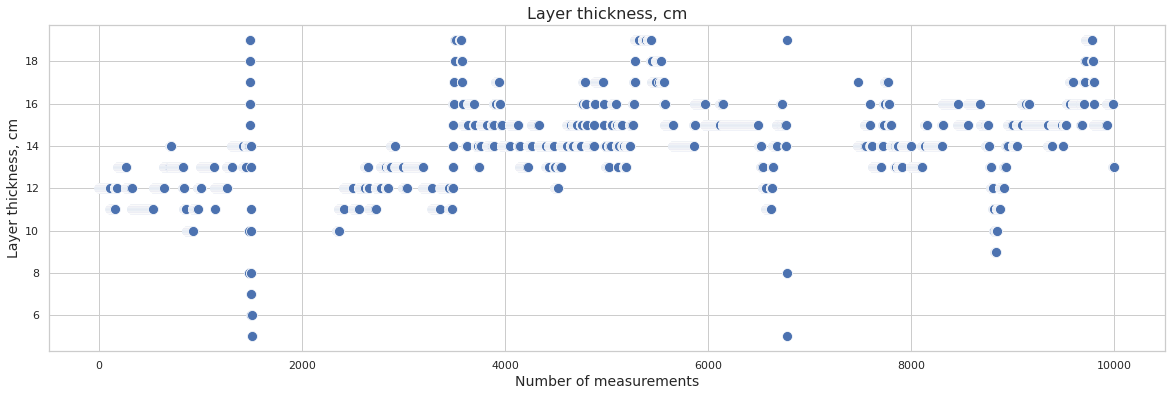

In [63]:
# here and in all code cells below, you can make changes and execute cells by clicking Run

# the uploaded file with a interfaces thickness of the layer. Copy its name along with the extension and insert it below between quotation marks
layer_thickness = pd.read_csv('_19_ 08.11.2018 13_02_30_sav_l1.del', sep=' ', decimal=',', header=0)

layer_thickness = layer_thickness[['Number', 'of', 'frame:']]
layer_thickness.columns = ['frame_number', 'first_limit_ns', 'second_limit_ns']

# formula for calculating layer thickness from the difference in time of signal reflection from two borders
layer_thickness['layer_thickness'] = ((layer_thickness['second_limit_ns']-layer_thickness['first_limit_ns'])*15*0.49).astype(int) # for asphalt

# to calculate the thickness of the layer for snow, in the formula above, you need to insert a coefficient of 0.707 instead of 0.49
# to calculate the thickness of the layer for ice, in the formula above, you need to insert a coefficient of 0.56 instead of 0.49

# define abnormal values in 99% of the thickness values. If you don't put the # at the beginning of the line
outlier = layer_thickness['layer_thickness'].quantile(.99)
print('Abnormal values in 99% of the thickness values:', int(outlier), 'cm and more', '\n')

# delete the parts of the tables where the layer thickness is less than 5 cm (where the car stops) and more than abnormal values
# if not necessary, put # before the beginning of the line
layer_thickness = layer_thickness.query('5 <= layer_thickness < @outlier').reset_index(drop=True)

# you can output any number of rows in the table. you need to specify it in brackets after head or tail
print('First 5 rows of the layer thickness table:')
display(layer_thickness.head(5))
print('Last 5 rows of the layer thickness table:')
display(layer_thickness.tail(5))
print('Total layer thickness measurement points:', len(layer_thickness))

f, ax = plt.subplots(figsize = (20,6))
sns.scatterplot(x = "frame_number", y = "layer_thickness", data = layer_thickness, s=100)
plt.title("Layer thickness, cm", fontsize = 16) 
plt.xlabel("Number of measurements", fontsize = 14) 
plt.ylabel("Layer thickness, cm", fontsize = 14) 
#plt.ylim(0, 100) # if you want to set the range on the y axis, remove the grid icon at the beginning of the line and enter the desired values
plt.show()

#### Conclusions

- uploaded a file with the layer thickness interfaces
- calculated the thickness of the layer from the difference in time of reflection of the signal from the two interfaces. It depends on the coefficient k=(permittivity) (-0.5) (i.e. to the degree of -1/2). Reference value k for asphalt = 0.49. When calibrating the device (when comparing the thickness of the layer determined by the device and from the taken core - the sample of asphalt ), the coefficient can be adjusted so that the values obtained by both methods coincide
- determined abnormal values in 99% of the layer thickness values. These are most likely errors in defining interfaces
- there were places where the car stopped on the recording. When correcting the thickness interfaces in these places, they were manually reduced close to each other (they became less than 5 cm). Deleting table rows in these places
- output the first and last rows of the table with a certain layer thickness and the number of points for measuring the layer thickness after removing the car stops
- built a graph showing the layer thickness values at all measurement points. It clearly shows the most frequent layer thickness values, the minimum and maximum layer thickness values, where they are located in the record, and where the car stops (empty areas)

Statistics of layer thickness values:
count    8348.0
mean       14.0
std         2.0
min         5.0
25%        13.0
50%        14.0
75%        15.0
max        19.0
Name: layer_thickness, dtype: float64
The most common value for layer thickness (mode): 15 cm
The number of occurring values of the layer thickness: 15


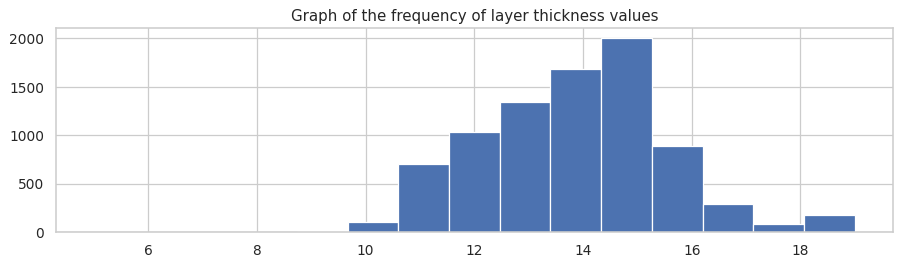

In [64]:
# you can view statistics on the thickness of the layer. mean-average layer thickness, min/max-minimum and maximum layer thickness
# 50% - the median (most frequent) value of layer thickness
print('Statistics of layer thickness values:')
print(layer_thickness['layer_thickness'].describe().round(0))
print('The most common value for layer thickness (mode):', int(layer_thickness['layer_thickness'].mode()),'cm')

bins_number = len(layer_thickness['layer_thickness'].value_counts())
print('The number of occurring values of the layer thickness:', bins_number)

# distribution of layer thickness values
plt.figure(figsize=(12,3), dpi= 90)
layer_thickness['layer_thickness'].hist(bins=bins_number)
plt.title('Graph of the frequency of layer thickness values', fontsize=12)
#plt.xlim(0, 100) # if you want to set the range on the y axis, remove the grid icon at the beginning of the line and enter the desired values
plt.show()

#### Conclusions

- showed statistics on the thickness of the layer. Here mean is the average layer thickness, min/max is the minimum and maximum layer thickness, and 50% is the median layer thickness
- determined the most common value of the layer thickness (mode)
- determined the number of encountered layer thickness values
- output a graph of the frequency of layer thickness values. It shows which thicknesses are most common (the frequency value on the left of the y axis)

First 5 rows of the coordinate table:


,frame_number,latitude,longitude,latitude_diff,longitude_diff,distance_diff,latitude_diff_sum,longitude_diff_sum,distance
0,17,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
1,39,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
2,70,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
3,87,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0
4,106,55.773087,37.518773,0.0,0.0,0.0,0.0,0.0,0.0


Last 5 rows of the coordinate table:


,frame_number,latitude,longitude,latitude_diff,longitude_diff,distance_diff,latitude_diff_sum,longitude_diff_sum,distance
377,9860,55.770820,37.516947,0.93,0.66,1.14,-251.76,-145.02,1218.7
378,9878,55.770863,37.516980,4.82,2.64,5.50,-246.94,-142.38,1224.2
379,9902,55.770885,37.517000,2.41,1.59,2.89,-244.53,-140.79,1227.1
380,9953,55.770912,37.517022,2.96,1.72,3.42,-241.57,-139.07,1230.5
381,9978,55.770938,37.517045,2.96,1.85,3.49,-238.61,-137.22,1234.0


Total coordinate points: 382
Average distance between coordinate points: 3.23 m
Average distance between layer thickness measurement points: 15 cm
Average speed of movement during measurement: 25 km/h


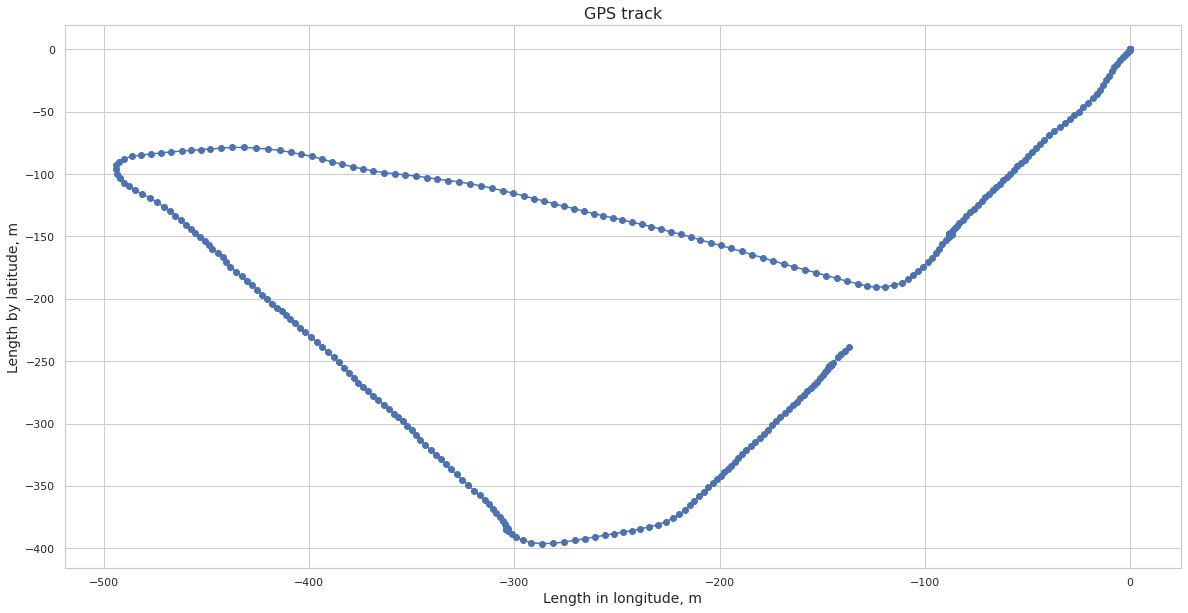

In [65]:
# uploading a file with coordinates. Copy its name along with the extension and insert it below between quotation marks
gps_track = pd.read_csv('_19_ 08.11.2018 13_02_30 en.gps', sep=' ', decimal=',', header=0, names=['frame_number','longitude','latitude','NaN', 'Nan'])

gps_track = gps_track.drop(['NaN', 'Nan'], axis = 1)
neworder = ['frame_number','latitude','longitude']
gps_track=gps_track.reindex(columns=neworder)

# we calculate the difference between the coordinate points in meters
gps_track['latitude_diff'] = (gps_track['latitude'].diff() * 111134.861111).round(2)
gps_track['longitude_diff'] = (gps_track['longitude'].diff() * 111321.377778 * math.cos(gps_track['latitude'].mean())).round(2)
gps_track = gps_track.fillna(0)

# we calculate the length of each section between the coordinate points
gps_track['distance_diff'] = ((gps_track['latitude_diff']**2 + gps_track['longitude_diff']**2)**(0.5)).round(2)

# we calculate the total length and lengths by coordinates, summing the lengths by sections
lengps = len(gps_track)-1
gps_track['latitude_diff_sum'] = gps_track['latitude_diff'].rolling(min_periods=1,window=lengps).sum()
gps_track['longitude_diff_sum'] = gps_track['longitude_diff'].rolling(min_periods=1,window=lengps).sum()
gps_track['distance'] = gps_track['distance_diff'].rolling(min_periods=1,window=lengps).sum().round(1)
gps_track = gps_track.loc[gps_track['frame_number'] != lengps]

print('First 5 rows of the coordinate table:')
display(gps_track.head(5))
print('Last 5 rows of the coordinate table:')
display(gps_track.tail(5))
print('Total coordinate points:', len(gps_track))

print('Average distance between coordinate points:', (gps_track.tail(1).loc[len(gps_track)-1,'distance'] / len(gps_track)).round(2), 'm')
print('Average distance between layer thickness measurement points:',int((gps_track.tail(1).loc[len(gps_track)-1,'distance'] / len(layer_thickness)*100).round(0)), 'cm')
print('Average speed of movement during measurement:',int(gps_track.tail(1).loc[len(gps_track)-1,'distance'] / layer_thickness['frame_number'].max() * 56.8 *3.6), 'km/h') 
# here 56.8 is the measurement frequency per second

f, ax = plt.subplots(figsize = (20,10))
plt.plot(gps_track.longitude_diff_sum, gps_track.latitude_diff_sum, marker="o")
plt.title("GPS track", fontsize = 16) 
plt.ylabel("Length by latitude, m", fontsize = 14)
plt.xlabel("Length in longitude, m", fontsize = 14) 
plt.show()

#### Conclusions

- uploaded a file with coordinates
- calculated the distance between coordinate points in meters and the length of each section between coordinate points
- calculated the total length and lengths by coordinates, summing the lengths of sections
- calculated the average distance between coordinate points
- calculated the average distance between the layer thickness measurement points
- calculated the average speed of movement when measuring
- output the first and last rows of the coordinate table and the number of coordinate points
- built a graph with a GPS track. It matches the GPS track on the map from the PicoR program

In [0]:
# uploading a file with labels. Copy its name along with the extension and insert it below between quotation marks
labels = pd.read_csv('_19_ 08.11.2018 13_02_30 en1.lab', sep='.', header=0, names=['label_number', 'frame_number'])

labels['frame_number'] = labels['frame_number'].astype(int)
labels['label_number'] = labels['label_number'].astype(int)
labels = labels.drop(index=[0]).reset_index(drop=True) # deleting the entry start label
labels = labels.loc[labels['frame_number'] != labels['frame_number'].max()] # .reset_index(drop=True)
for i in labels['label_number']: # changing the order of labels based on the deleted label of the beginning of the record
    labels['label_number'].replace(i, i-1, inplace=True)

#### Conclusions

- uploaded a file with labels
- brought the table with labels to numbering, as they look on the record
- output a table of labels (as they are shown on the record) with the layer thickness

First 5 rows of the final table of layer thickness by profile:


,frame_number,latitude,longitude,layer_thickness,thickness_category,distance
0,17,55.773087,37.518773,12,thickness 11-15 cm,0.0
1,39,55.773087,37.518773,12,thickness 11-15 cm,0.0
2,70,55.773087,37.518773,12,thickness 11-15 cm,0.0
3,87,55.773087,37.518773,12,thickness 11-15 cm,0.0
4,106,55.773087,37.518773,12,thickness 11-15 cm,0.0


Last 5 rows of the final table of layer thickness by profile:


,frame_number,latitude,longitude,layer_thickness,thickness_category,distance
314,9860,55.770820,37.516947,15,thickness 11-15 cm,1218.7
315,9878,55.770863,37.516980,15,thickness 11-15 cm,1224.2
316,9902,55.770885,37.517000,15,thickness 11-15 cm,1227.1
317,9953,55.770912,37.517022,16,thickness 16-20 cm,1230.5
318,9978,55.770938,37.517045,16,thickness 16-20 cm,1234.0


Total points for measuring layer thickness by profile: 319


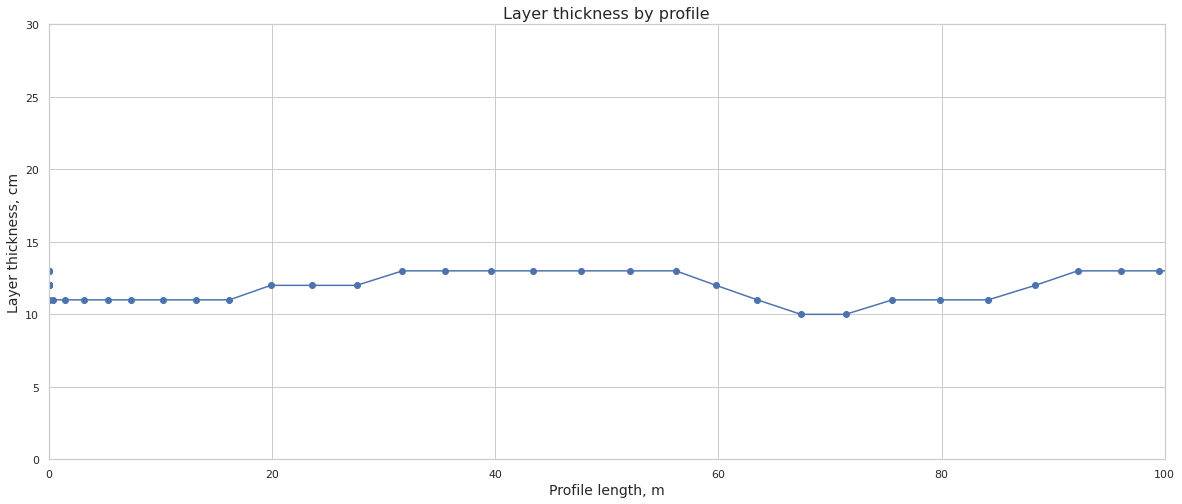

In [67]:
# introduce several categories depending on the layer thickness. Here you can enter your own ranges and delete extra lines
def thickness_category(layer_thickness):
    if 5 <= layer_thickness <= 10:
        return 'thickness 5-10 cm'
    if 10 < layer_thickness <= 15:
        return 'thickness 11-15 cm'
    if 15 < layer_thickness <= 20:
        return 'thickness 16-20 cm'
    else:
        return 'thickness > 20 cm'
layer_thickness['thickness_category'] = layer_thickness['layer_thickness'].apply(thickness_category)

# combine the table with the thickness of the layer and coordinates
final_data = layer_thickness.merge(gps_track, on='frame_number')

final_data1 = final_data[['frame_number', 'longitude_diff_sum','latitude_diff_sum', 'layer_thickness','thickness_category',
                          'distance']]
final_data = final_data[['frame_number', 'latitude','longitude', 'layer_thickness', 'thickness_category', 'distance']]

print('First 5 rows of the final table of layer thickness by profile:')
display(final_data.head(5))
print('Last 5 rows of the final table of layer thickness by profile:')
display(final_data.tail(5))
print('Total points for measuring layer thickness by profile:', len(final_data))

f, ax = plt.subplots(figsize = (20,8))
plt.plot(final_data.distance, final_data.layer_thickness, marker="o")
plt.title("Layer thickness by profile", fontsize = 16) 
plt.xlabel("Profile length, m", fontsize = 14) 
plt.ylabel("Layer thickness, cm", fontsize = 14) 
plt.xlim(0, 100) # if you want to adjust the range along the x axis, enter the desired values
plt.ylim(0, 30) # if you want to adjust the range along the y axis, enter the desired values
plt.show()

In [68]:
# if we see thin or thick layer in some place on the chart and we need to find out the thickness there and locate the place
# you need to enter the interface thickness of layer in the condition below and the desired thickness and distance will be displayed on the profile
display(final_data.query('layer_thickness < 10'))

,frame_number,latitude,longitude,layer_thickness,thickness_category,distance
59,1498,55.771882,37.517767,7,thickness 5-10 cm,156.5


#### Conclusions

- introduced several categories depending on the thickness of the layer: thickness 5-10 cm, thickness 11-15 cm, thickness 16-20 cm, thickness more than 20 cm
- combined tables with layer thickness and coordinates, got the final_data table, and output the first and last 5 rows
- built an important graph of the layer thickness by profile. It shows the entire profile of recording layer thickness from distance. By changing the xlim and ylim parameters you can view any section and any range of layer thicknesses
- if necessary, you can localize the place and output the desired table rows by specifying the condition by thickness

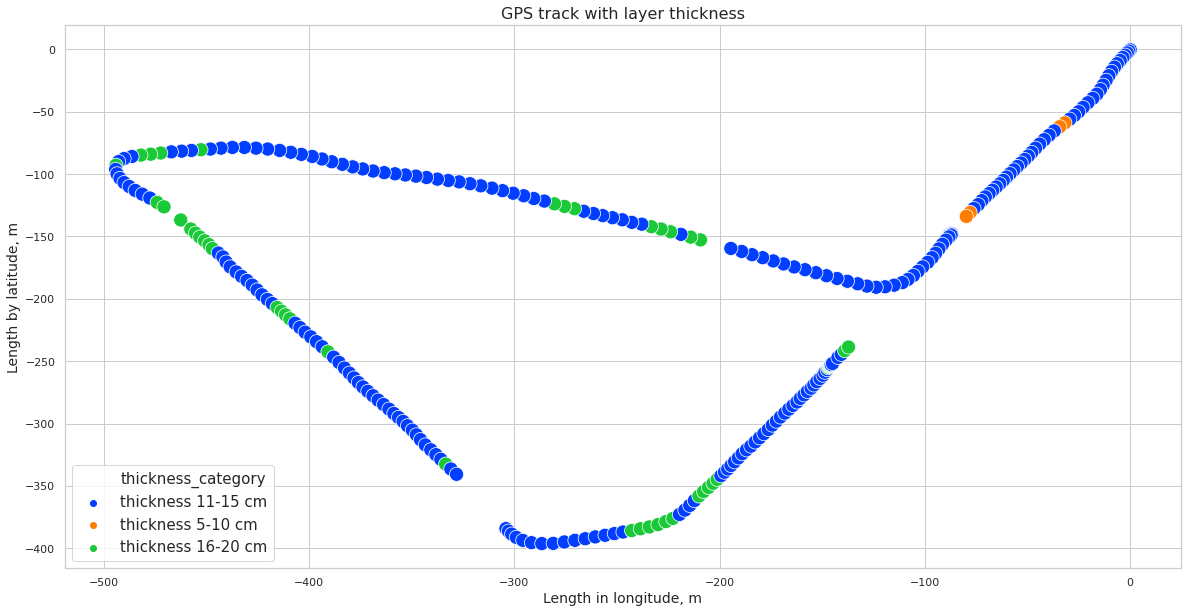

In [69]:
# plot a GPS track with overlay information about the layer thickness category
# gaps in the track - stops, and deleted the "empty" measurements

f, ax = plt.subplots(figsize = (20,10))
sns.scatterplot(x = "longitude_diff_sum", y = "latitude_diff_sum", data = final_data1, hue = "thickness_category", 
                palette="bright", s=200)
plt.title("GPS track with layer thickness", fontsize = 16) 
plt.xlabel("Length in longitude, m", fontsize = 14)
plt.ylabel("Length by latitude, m", fontsize = 14)
#plt.xlim(-40, -30) # if you want to adjust the range along the x axis, enter the desired values
#plt.ylim(-800, -600) # if you want to adjust the range along the y axis, enter the desired values
plt.legend(loc = 3, prop={'size': 15}) # if this window interferes with the graph output, you can move it (loc from 1 to 4)
plt.show()



In [70]:
# build an interactive graph of the GPS track, the values of layer thickness and distance can be viewed by moving the mouse cursor

alt.Chart(final_data1).mark_circle(size=80).encode(
    x='longitude_diff_sum',
    y='latitude_diff_sum',
    color=alt.Color('thickness_category', scale=alt.Scale(scheme='category10')),
    tooltip=['layer_thickness', 'distance']
).interactive().properties(
    width=1000,
    height=500,
    title='Interactive graph of the GPS track with values of layer thickness and distance'
)

alt.Chart(...)

In [0]:
# save this graph to an interactive html file

chart1 = alt.Chart(final_data1).mark_circle(size=80).encode(
    x='longitude_diff_sum',
    y='latitude_diff_sum',
    color=alt.Color('thickness_category', scale=alt.Scale(scheme='category10')),
    tooltip=['layer_thickness', 'distance']
).interactive().properties(
    width=1000,
    height=500,
    title='Interactive graph of the GPS track with values of layer thickness and distance'
)
chart1.save('chart1.html') 

In [72]:
# Creating a table with geographical coordinates using the library geopandas
import geopandas
gdf = geopandas.GeoDataFrame(
    final_data, geometry=geopandas.points_from_xy(final_data.longitude, final_data.latitude))
gdf.crs = {'init': 'epsg:4326'}
display(gdf.head())

,frame_number,latitude,longitude,layer_thickness,thickness_category,distance,geometry
0,17,55.773087,37.518773,12,thickness 11-15 cm,0.0,POINT (37.51877 55.77309)
1,39,55.773087,37.518773,12,thickness 11-15 cm,0.0,POINT (37.51877 55.77309)
2,70,55.773087,37.518773,12,thickness 11-15 cm,0.0,POINT (37.51877 55.77309)
3,87,55.773087,37.518773,12,thickness 11-15 cm,0.0,POINT (37.51877 55.77309)
4,106,55.773087,37.518773,12,thickness 11-15 cm,0.0,POINT (37.51877 55.77309)


In [73]:
# build an interactive graph of the GPS track on Openstreetmaps, the values of layer thickness and distance can be viewed by moving the mouse cursor

data = final_data[['latitude', 'longitude']].values.tolist()
map1 = folium.Map(location=data[-1], zoom_start=16)
folium.Circle(radius=10, location=data[0], popup='Start', color='green', fill=True,).add_to(map1) # Circle marker of green color of start point
folium.Circle(radius=10, location=data[-1], popup='End', color='red', fill=True,).add_to(map1) # Circle marker of red color of end point

#folium.Marker(location=data[0], popup = "Start", icon=folium.Icon(color = 'green')).add_to(map1)
#folium.Marker(location=data[-1], popup = "End", icon=folium.Icon(color = 'red')).add_to(map1)
#HeatMap(data=data, radius=10, max_zoom=22, blur=10, max_val=15).add_to(map1)

folium.GeoJson(
    gdf,
    name='final_data',
    style_function=None,
    tooltip=folium.GeoJsonTooltip(
        fields=['layer_thickness', 'distance'],
        localize=False
        ),
    smooth_factor = 0
).add_to(map1)

map1.save("map1.html") # save this graph to an interactive html file
map1

#### Conclusions
- built graph of GPS track with layer thickness
- built interactive graph of the GPS track with values of layer thickness and distance
- built interactive graph on Openstreetmaps of the GPS track with values of layer thickness and distance

In [74]:
# combine all tables (with interfaces, coordinates, and labels) into one)

layer_thickness_labels = layer_thickness.merge(labels, on='frame_number', how='left')
layer_thickness_labels = layer_thickness_labels.fillna('')

full_data = layer_thickness_labels.merge(gps_track, on='frame_number', how='left')
full_data = full_data.fillna(method='pad')
full_data = full_data.fillna(0)

full_data = full_data[['frame_number', 'label_number', 'layer_thickness','thickness_category', 'latitude','longitude', 
                        'longitude_diff_sum','latitude_diff_sum', 'distance']]

full_data_label = full_data.query('label_number != ""')
#full_data_label['label_number'] = full_data_label['label_number'].astype(int)

print('Final table with all data for the layer (last 5 rows):')
display(full_data.tail())

#display(full_data.loc[2970:2990]) # to display the range of rows in the table (as specified in [])
#full_data.loc[16,'label_number'] = 1 # to manually set any cell value

print('Summary table with label data for the layer:')
display(full_data_label)

Final table with all data for the layer (last 5 rows):


,frame_number,label_number,layer_thickness,thickness_category,latitude,longitude,longitude_diff_sum,latitude_diff_sum,distance
8343,9996,,13,thickness 11-15 cm,55.770938,37.517045,-137.22,-238.61,1234.0
8344,9997,,13,thickness 11-15 cm,55.770938,37.517045,-137.22,-238.61,1234.0
8345,9998,,13,thickness 11-15 cm,55.770938,37.517045,-137.22,-238.61,1234.0
8346,9999,,13,thickness 11-15 cm,55.770938,37.517045,-137.22,-238.61,1234.0
8347,10000,,13,thickness 11-15 cm,55.770938,37.517045,-137.22,-238.61,1234.0


Summary table with label data for the layer:


,frame_number,label_number,layer_thickness,thickness_category,latitude,longitude,longitude_diff_sum,latitude_diff_sum,distance
2618,3461,1,11,thickness 11-15 cm,55.771628,37.516388,-189.25,-161.99,306.5
4229,5119,2,14,thickness 11-15 cm,55.772220,37.512545,-494.23,-96.21,633.6


#### Conclusions
- got a full_data table where all the information on layer thicknesses, coordinates, and labels is collected
- got the full_data_label table, where all the full_data information on labels is output

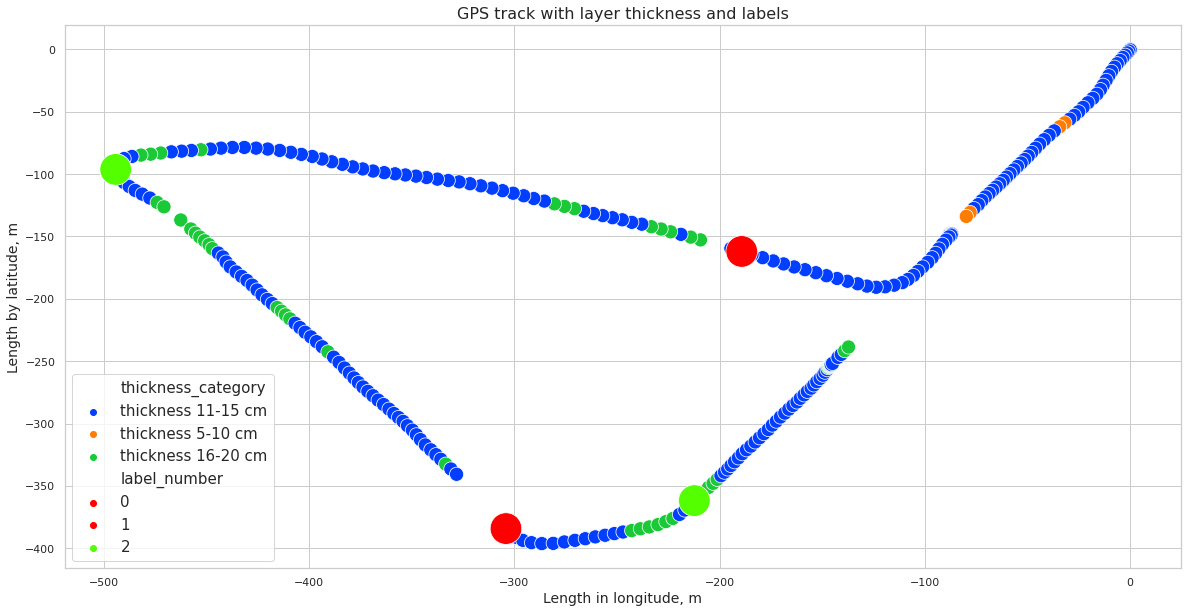

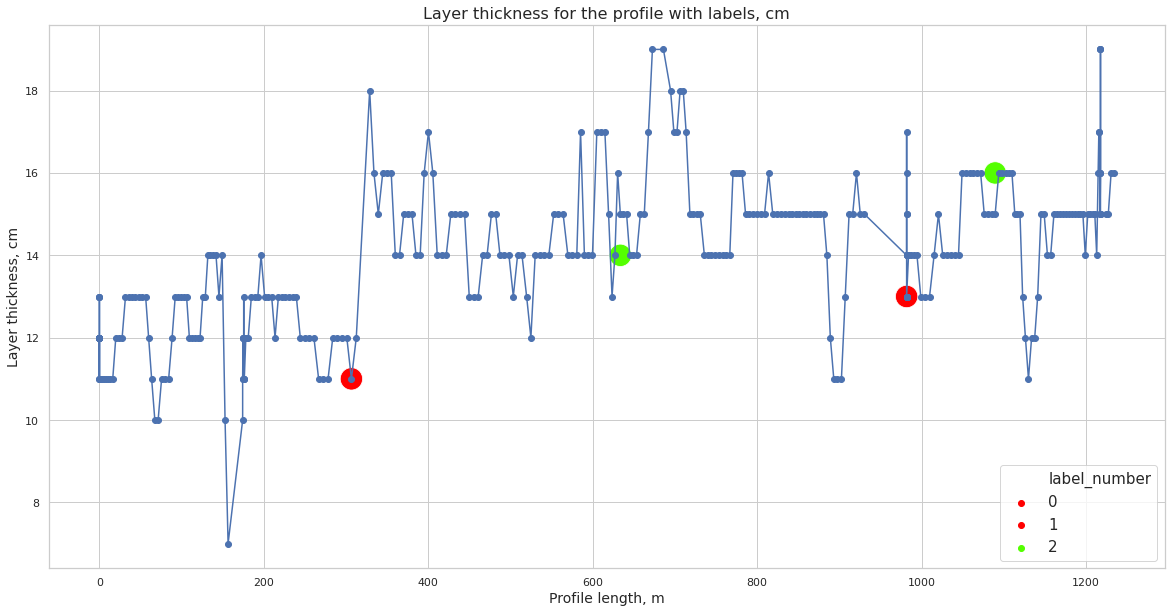

In [75]:
# plot a GPS track graph with the layer thickness and labels
# the graph first shows the numbers of the "red" labels set in measurement mode,
# then the numbers of the "blue" labels set in processing mode
f, ax = plt.subplots(figsize = (20,10))
sns.scatterplot(x = "longitude_diff_sum", y = "latitude_diff_sum", data = final_data1, hue = "thickness_category", 
                palette="bright", s=200)
sns.scatterplot(x = "longitude_diff_sum", y = "latitude_diff_sum", data = full_data_label_d, hue = "label_number", 
                palette="prism", s=1000) 
plt.title("GPS track with layer thickness and labels", fontsize = 16) 
plt.xlabel("Length in longitude, m", fontsize = 14)
plt.ylabel("Length by latitude, m", fontsize = 14)
#plt.xlim(-200, -100) # if you want to adjust the range along the x axis, enter the desired values
#plt.ylim(-250, -600) # if you want to adjust the range along the y axis, enter the desired values
plt.legend(loc = 3, prop={'size': 15})
plt.show()

# plot the layer thickness based on the profile with labels
# the graph first shows the numbers of the "red" labels set in measurement mode,
# then the numbers of the "blue" labels set in processing mode
f, ax = plt.subplots(figsize = (20,10))
plt.plot(final_data.distance, final_data.layer_thickness, marker="o")
sns.scatterplot(x = "distance", y = "layer_thickness", data = full_data_label_d, hue = "label_number",palette="prism", s=500)
plt.title("Layer thickness for the profile with labels, cm", fontsize = 16) 
plt.xlabel("Profile length, m", fontsize = 14) 
plt.ylabel("Layer thickness, cm", fontsize = 14) 
#plt.ylim(0, 30) # if you want to adjust the range along the y axis, enter the desired values
plt.legend(loc = 4, prop={'size': 15})
plt.show()



In [76]:
chart1 = alt.Chart(final_data1).mark_circle(size=60).encode(
    x='longitude_diff_sum',
    y='latitude_diff_sum',
    color=alt.Color('thickness_category', scale=alt.Scale(scheme='category10')),
    tooltip=['layer_thickness', 'distance']
).interactive().properties(width=1000, height=500)

chart12 = alt.Chart(full_data_label).mark_circle(size=500).encode(
    x='longitude_diff_sum',
    y='latitude_diff_sum',
    color=alt.Color('label_number:O', scale=alt.Scale(scheme='set1')),
    tooltip=['layer_thickness', 'distance']
).interactive().properties(width=1000, height=500, title='Interactive graph of the GPS track and labels with values of layer thickness and distance')

chart2 = chart1 + chart12
chart2 

alt.LayerChart(...)

In [0]:
chart2.save('chart2.html') 

#### Conclusions

- built important plots "GPS track with layer thickness and labels" and "Layer thickness by profile with labels". The thickness categories and label numbers are indicated in the plot legend
- built interactive graph of the GPS track and labels with values of layer thickness and distance

In [0]:
# upload tables to excel file
final_data.to_excel("final_data.xlsx")
full_data.to_excel("full_data.xlsx")
full_data_label.to_excel("full_data_label.xlsx")

In [0]:
# if there is an error uploading to an excel file, remove the grid before pip, install openpyxl, and re-upload
#pip install openpyxl

To create a report you can use the downloaded summary tables final_data.xlsx, full_data.xlsx, full_data_label.xlsx, images of graphs "GPS track with layer thickness and labels", "Layer thickness by profile with labels", "Layer thickness by profile", "GPS track", "Layer thickness", "Graph of frequency of layer thickness values", layer thickness values in labels and other data